# Auto encoders 

Author: Gabriel Rodrigues Palma

additional source: DataCamp and MIT introduction to Deep Learning

## Loading the packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keract import get_activations, display_activations

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [74]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Important functions

In [4]:
def transformToBinary(data):
    reshapedData = np.array(data).reshape(len(data), -1)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(reshapedData)    
    return(onehot_encoded)

In [5]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = X_test
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(2, 5))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(2, 5))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(2, 5))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Real vs Decoded images')
    plt.show()

In [6]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [7]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 5
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

## Loading the data and visualizing it

In [8]:
data = pd.read_csv('../Data/5G-production-dataset/Download/Static/B_2019.12.16_13.40.04.csv')

In [9]:
encoded_text_data = transformToBinary(data['PINGMAX'])

In [10]:
data.describe()

,Longitude,Latitude,Speed,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,UL_bitrate,RAWCELLID
count,2.143000e+03,2.143000e+03,2143.0,2143.0,2143.000000,2143.000000,2143.000000,2143.00000,2143.000000,2143.000000,2143.0
mean,-8.394628e+00,5.188614e+01,0.0,11.0,-95.999067,-13.856276,3.717219,10.65329,50382.109193,141.879608,10805003.0
std,1.221694e-07,9.162706e-08,0.0,0.0,1.274617,2.239170,3.260739,1.91965,65620.519457,122.211380,0.0
min,-8.394628e+00,5.188614e+01,0.0,11.0,-104.000000,-19.000000,-7.000000,6.00000,0.000000,0.000000,10805003.0
25%,-8.394628e+00,5.188614e+01,0.0,11.0,-96.000000,-16.000000,2.000000,10.00000,3229.500000,44.000000,10805003.0
50%,-8.394628e+00,5.188614e+01,0.0,11.0,-96.000000,-14.000000,4.000000,11.00000,23853.000000,128.000000,10805003.0
75%,-8.394628e+00,5.188614e+01,0.0,11.0,-95.000000,-12.000000,6.000000,11.00000,61175.000000,215.000000,10805003.0
max,-8.394624e+00,5.188614e+01,0.0,11.0,-93.000000,-9.000000,15.000000,15.00000,302694.000000,1215.000000,10805003.0


In [11]:
data = data[['CellID','RSRP','RSRQ','SNR','CQI','DL_bitrate','UL_bitrate','RAWCELLID']]

In [12]:
data

,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,UL_bitrate,RAWCELLID
0,11,-103,-15,1.0,15,72,20,10805003
1,11,-102,-16,7.0,15,0,0,10805003
2,11,-102,-16,7.0,15,0,0,10805003
3,11,-102,-16,7.0,15,0,0,10805003
4,11,-104,-14,-7.0,11,0,0,10805003
...,...,...,...,...,...,...,...,...
2138,11,-98,-11,2.0,14,242467,311,10805003
2139,11,-98,-11,2.0,14,214448,247,10805003
2140,11,-99,-13,8.0,8,246969,228,10805003
2141,11,-99,-13,8.0,8,251152,252,10805003


In [13]:
data = minmax_scale(data)

In [28]:
encoded_text_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [14]:
data = np.hstack((data, encoded_text_data))

In [15]:
data.shape

(2143, 42)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.3, random_state=42)

## Implementing auto encoders with MNIST data

In [75]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(30, input_shape=(42, ), activation="relu"))
autoencoder.add(Dense(20, input_shape=(42, ), activation="relu"))
# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(42, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 30)                1290      
                                                                 
 dense_16 (Dense)            (None, 20)                620       
                                                                 
 dense_17 (Dense)            (None, 10)                210       
                                                                 
 dense_18 (Dense)            (None, 5)                 55        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_19 (Dense)            (None, 10)                60        
                                                                 
 dense_20 (Dense)            (None, 20)               

In [ ]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(30, input_shape=(42, ), activation="relu"))
autoencoder.add(Dense(20, activation="relu"))
autoencoder.add(Dense(10, activation="relu"))
autoencoder.add(Dense(5, activation="relu"))
autoencoder.add(Dropout(0.7))
autoencoder.add(Dense(10, activation="relu"))
autoencoder.add(Dense(20, activation="relu"))
autoencoder.add(Dense(30, activation="relu"))
# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(42, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

In [18]:
X_train

array([[0.        , 0.72727273, 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.63636364, 0.3       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.72727273, 0.7       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.72727273, 0.7       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.81818182, 0.7       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.81818182, 0.4       , ..., 0.        , 0.        ,
        0.        ]])

In [80]:
# training the model
autoencoder.fit(X_train, X_train, epochs=1000)

Epoch 1/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1308 - accuracy: 0.8747
Epoch 2/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1327 - accuracy: 0.8747
Epoch 3/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1315 - accuracy: 0.8747
Epoch 4/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.8747
Epoch 5/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1309 - accuracy: 0.8747
Epoch 6/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1320 - accuracy: 0.8747
Epoch 7/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1308 - accuracy: 0.8747
Epoch 8/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.8747
Epoch 9/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.8747
Epoch 10/1000
47/47 [==============================] - 0s 6ms/step - loss: 0.1307 - accuracy: 0.8747

In [77]:
autoencoder_accuracy = pd.DataFrame(autoencoder.history.history['accuracy'])
autoencoder_loss = pd.DataFrame(autoencoder.history.history['loss'])

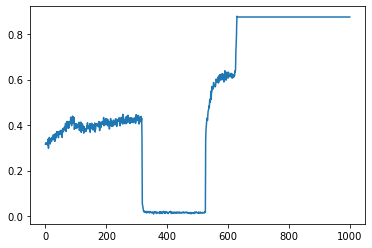

In [78]:
plt.plot(autoencoder_accuracy)
plt.show()

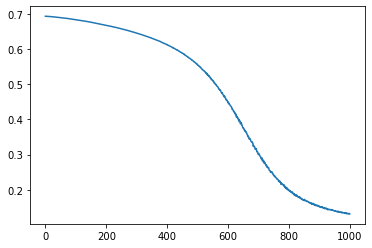

In [79]:
plt.plot(autoencoder_loss)
plt.show()

In [27]:
autoencoder_accuracy.to_csv('../../Results/5GdatasetAutoencoderAccuracy.csv')
autoencoder_loss.to_csv('../../Results/5GdatasetAutoencoderLoss.csv')

In [65]:
#autoencoder.save_weights('autoencoder_weights.h5')

In [59]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_train)
#show_encodings(encodings, number = 1)

2022-06-16 15:45:42.691966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [68]:
encodings.shape
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(X_train)

In [69]:
X_train.shape

(1500, 42)

In [70]:
sum(X_train -np.round(decoded_imgs))

array([   0.        , -414.36363636, -676.8       ,  653.63636364,
       -716.22222222,  257.63878372,  176.22469136,    0.        ,
       -110.        ,    1.        ,    1.        ,    2.        ,
          1.        ,    0.        ,    0.        ,    1.        ,
          2.        ,    1.        ,    0.        ,    1.        ,
          0.        ,    0.        ,    1.        ,    1.        ,
          0.        ,    1.        ,    2.        ,   14.        ,
         17.        ,   18.        ,    8.        ,    7.        ,
          4.        ,    5.        ,   11.        ,    4.        ,
          2.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ])

In [63]:
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(X_test)
X_test[0:1].shape

(1, 42)

In [64]:
import collections
activations = get_activations(autoencoder, X_test[0:1])
subset = lambda d, *keys: [(key, d[key]) for key in d.keys() if key in set(keys)]
new_set = collections.OrderedDict(subset(activations, 'dense_input', 'dense_1', 'dense_2'))

In [65]:
print(activations['dense_input'])
print(activations['dense_2'])

[[0.         0.72727273 0.2        0.45454545 0.22222222 0.05013644
  0.0872428  0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[[0.00181916 0.706796   0.5307429  0.48813263 0.5152505  0.19549532
  0.13828968 0.00328991 0.9420802  0.00332182 0.00154548 0.00332439
  0.00247643 0.00266394 0.00226763 0.00284835 0.00304987 0.00275831
  0.00161607 0.00290346 0.0027505  0.00183822 0.00330875 0.00371225
  0.00303671 0.00373915 0.00222593 0.00726009 0.00936668 0.00235595
  0.0044457  0.00143241 0.00408051 0.00421041 0.0047483  0.00444333
  0.00241996 0.00329562 0.00190116 0.00253728 0.00309774 0.00308174]]


In [ ]:
# input -> Encoded 
# Encoded CSV
# output as a CSV  
def return_orinal_data:
    

dense_input (1, 42) 


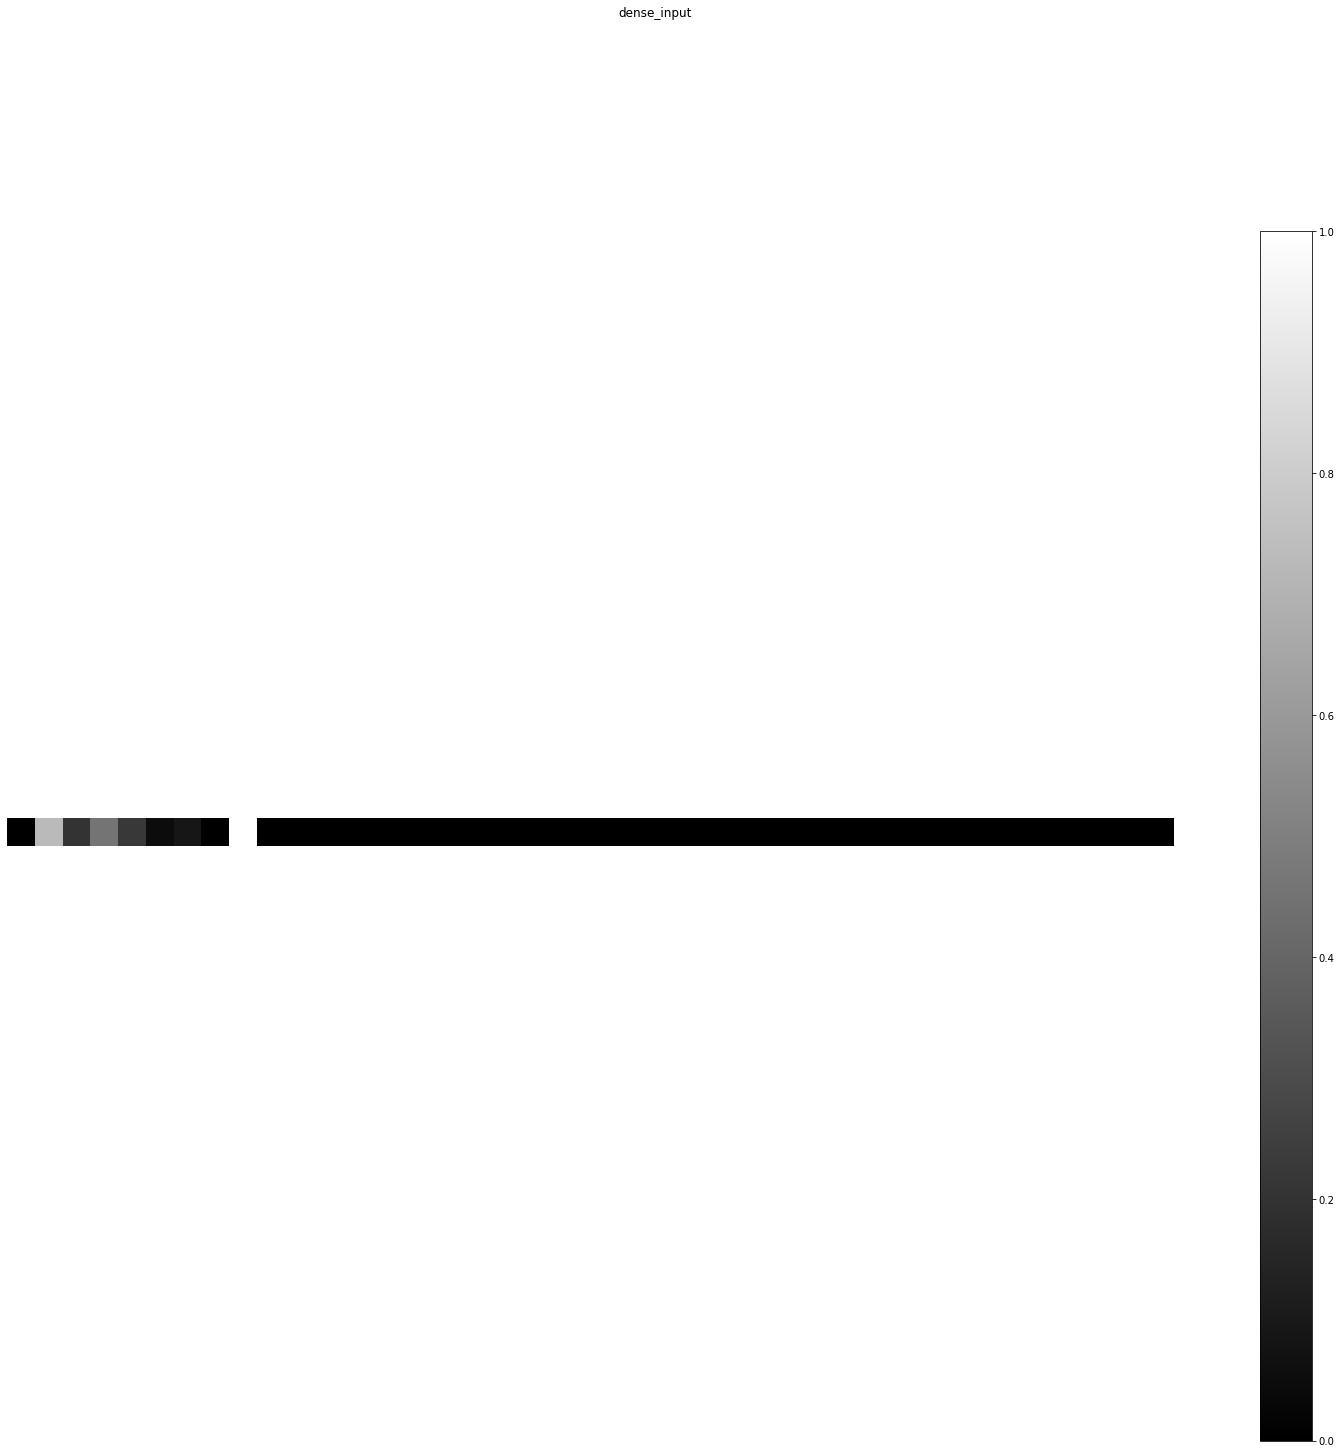

dense_1 (1, 20) 


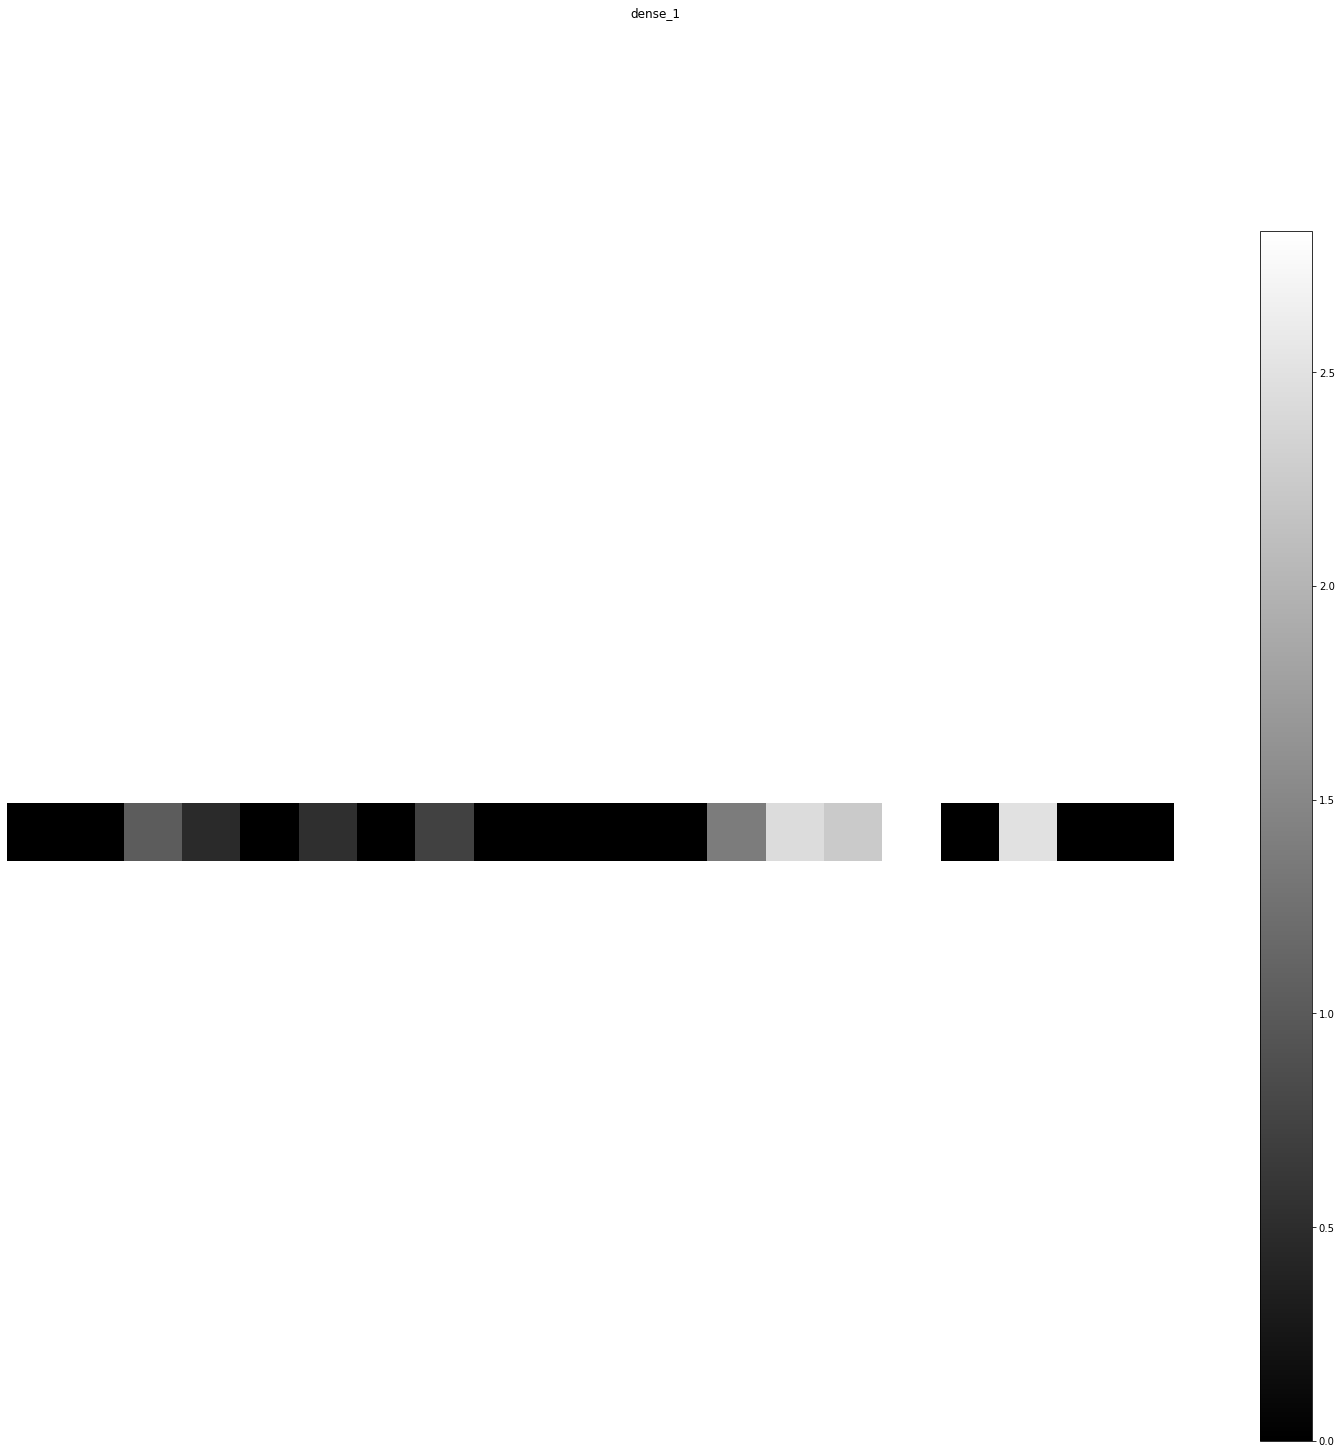

dense_2 (1, 42) 


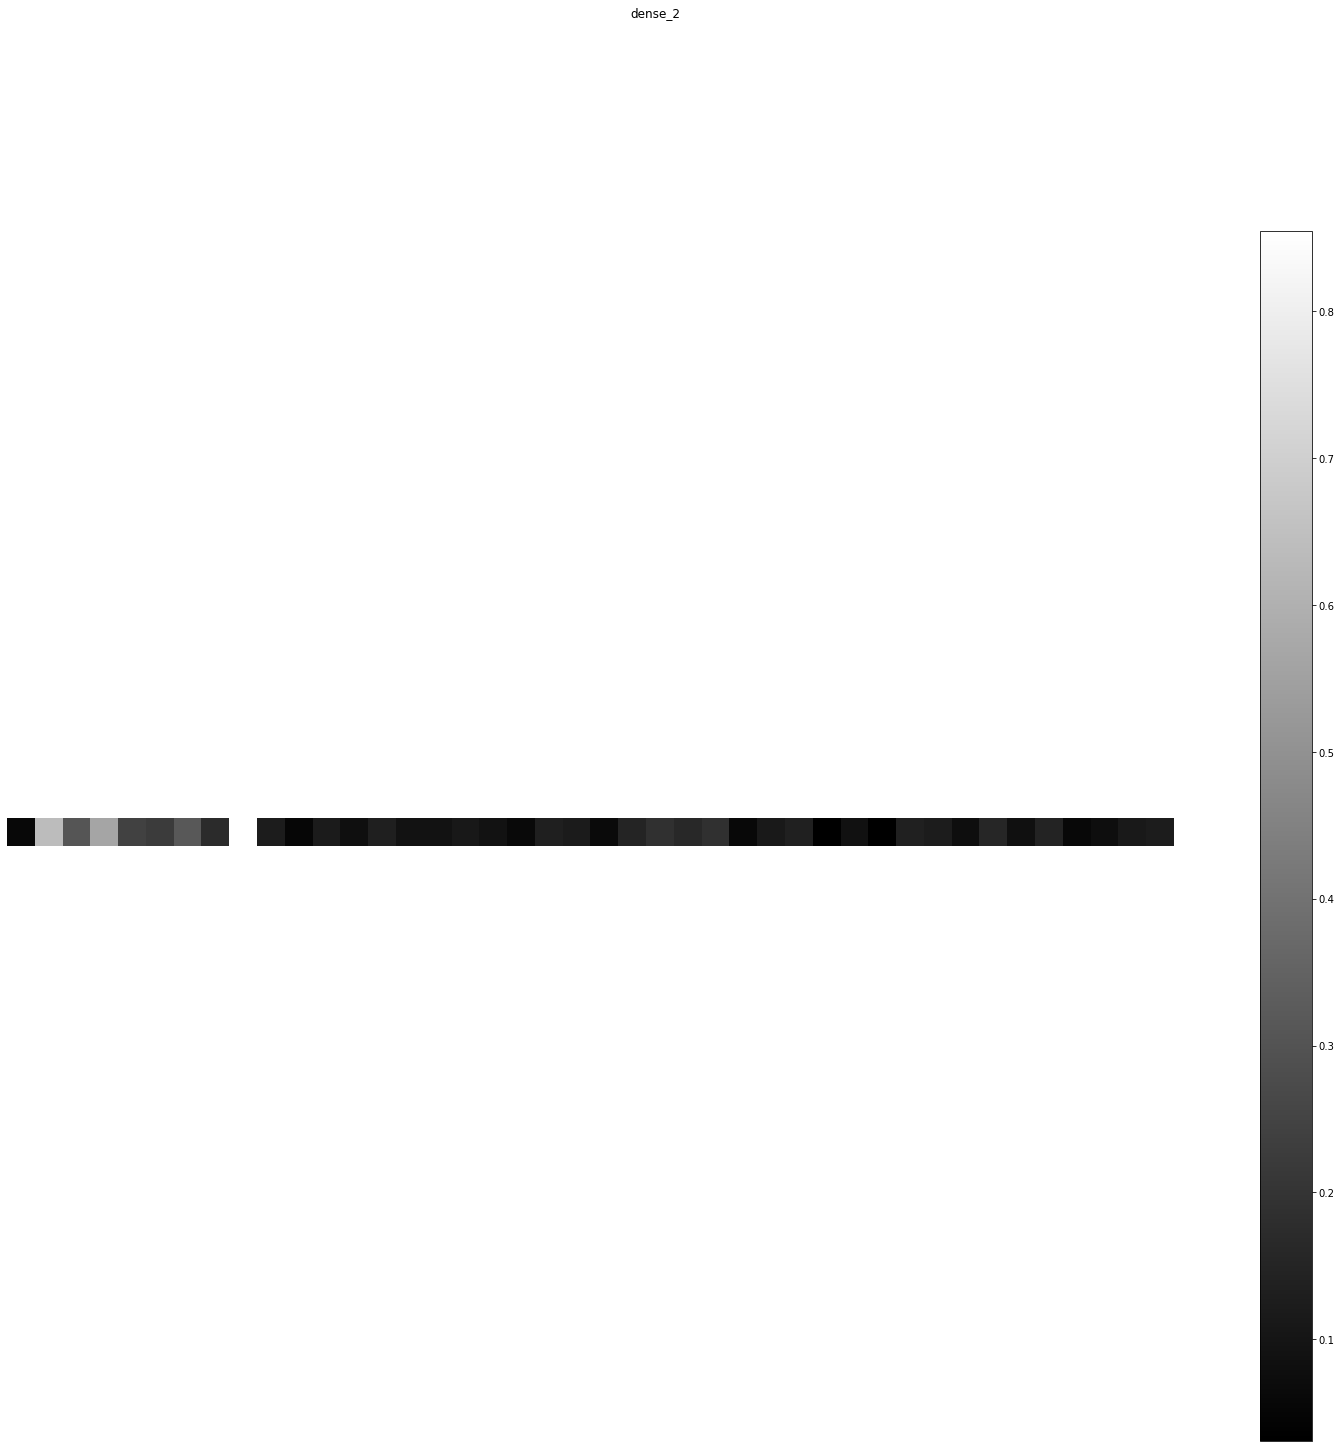

In [39]:
display_activations(new_set, cmap="gray", save=False, directory='../../Results/Plots')

# Implementing Variational Auto Encoders with MNIST data

In [37]:
class Sampling(layers.Layer):
    
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Creating the VA autoencoders 

In [66]:
#### Changing the image size
X_train_new = X_train.reshape(1500, 2, 5)

#### Build the encoder

In [88]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(2, 5, 1))
x = layers.Conv2D(32, 2, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 2, 5, 1)]    0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 1, 3, 32)     160         ['input_37[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 1, 2, 64)     8256        ['conv2d_8[0][0]']               
                                                                                                  
 flatten_6 (Flatten)            (None, 128)          0           ['conv2d_9[0][0]']               
                                                                                            

#### Build the decoder

In [92]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2 * 5 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((2, 5, 64))(x)
x = layers.Conv2DTranspose(64, 1, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 1, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_49 (Dense)            (None, 640)               1920      
                                                                 
 reshape_20 (Reshape)        (None, 2, 5, 64)          0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 2, 5, 64)         4160      
 Transpose)                                                      
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 2, 5, 1)          65        
 Transpose)                                                      
                                                                 
Total params: 6,145
Trainable params: 6,145
Non-trainable p

## Define the VAE as a Model with a custom train_step

In [93]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Training the models with MNIST data

In [96]:
X_train_new.shape

(1500, 2, 5)

In [99]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
# vae.fit(X_train_new, epochs=30, batch_size=1500)

## Plotting the Latent space

In [100]:
# plot_latent_space(vae)

In [101]:
# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train, y_train)